In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize


## Define GP functions

In [16]:
def arcsin_kernel_joint_gaussian(z1, z2, sigma_m, sigma_b, sigma_mb, eps=1e-12):
    '''
    arcsin kernel where m, b are drawn from a joint gaussian distribution
    Formula based on Williams 96 paper
    '''
    z1 = z1.reshape(-1,1)   # (N,1)
    z2 = z2.reshape(1,-1)   # (1,M)
    
    # numerator: Cov[m*z1 + b, m*z2 + b]
    num = sigma_m**2 * (z1 @ z2) + sigma_mb * (z1 + z2) + sigma_b**2
    
    # denominator pieces
    S1 = sigma_m**2 * (z1**2) + 2*sigma_mb*z1 + sigma_b**2 +1
    S2 = sigma_m**2 * (z2**2) + 2*sigma_mb*z2 + sigma_b**2  +1
    
    # ensure positivity
    S1 = np.maximum(S1, eps)
    S2 = np.maximum(S2, eps)
    
    rho = num / np.sqrt(S1 @ S2)
    rho = np.clip(rho, -1+eps, 1-eps)
    return (2/np.pi) * sigma_m**2 * np.arcsin(rho)

def neg_log_marginal_likelihood(params, z, y, noise_jitter=1e-6):
    '''
    Emperical bayes to find optimal hyper-parameters
    Function to compute neg Log ML
    parameterize via log_sm, log_sb, phi where sigma_mb = tanh(phi)*sigma_m*sigma_b
    '''
    log_sm, log_sb, phi = params
    sigma_m = np.exp(log_sm)
    sigma_b = np.exp(log_sb)
    rho     = np.tanh(phi)
    sigma_mb = rho * sigma_m * sigma_b

    # build kernel
    K = arcsin_kernel_joint_gaussian(z, z, sigma_m, sigma_b, sigma_mb)
    # add tiny noise for stability
    K[np.diag_indices(len(z))] += noise_jitter

    # Cholesky to ensure stability
    try:
        L = np.linalg.cholesky(K)
    except np.linalg.LinAlgError:
        return np.inf

    # compute alpha = K^{-1} y via solves
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
    # log det K = 2 sum log diag(L)
    logdet = 2.0 * np.sum(np.log(np.diag(L)))
    n = len(z)

    return 0.5 * (y @ alpha) + 0.5 * logdet + 0.5 * n * np.log(2*np.pi)


def gp_regression_eig_joint_gaussian(z_train, y_train, z_test,
                                     sigma_m, sigma_b, sigma_mb,
                                     sigma_n=1e-6, eigen_threshold=1e-8):
    '''
    Perform GP regression to make predictions
    '''
    # training covariances
    K = arcsin_kernel_joint_gaussian(z_train, z_train, sigma_m, sigma_b, sigma_mb)
    K += sigma_n**2 * np.eye(len(z_train))
    # cross cov
    K_s = arcsin_kernel_joint_gaussian(z_train, z_test, sigma_m, sigma_b, sigma_mb)
    # test cov
    K_ss = arcsin_kernel_joint_gaussian(z_test, z_test, sigma_m, sigma_b, sigma_mb)

    # eigen decomposition for stability
    evals, evecs = np.linalg.eigh(K)
    evals = np.maximum(evals, eigen_threshold)
    Kinv = (evecs * (1.0/evals)) @ evecs.T

    # predictive mean
    mu = K_s.T @ (Kinv @ y_train)
    # predictive covariance
    cov = K_ss - K_s.T @ (Kinv @ K_s)
    return mu, cov

## Define ODE

In [17]:
def fz(z):
    c = 2
    return ((-(z+7)*(z+4)*z*(z-4)*(z-7) + c*(z**2-16))/40000).flatten()

## Initialize Data

In [18]:
zrnge = 8  
dz = 0.01 
zgrid = np.arange(-zrnge, zrnge + dz, dz).reshape(-1, 1)


fgrid = fz(zgrid)

# training subset
n_train =  15
idx = np.linspace(0, len(zgrid)-1, n_train, dtype=int)
z_train = zgrid[idx]
y_train = fgrid[idx]

## Initialize Infinite RNN by defining kernel parameters

In [19]:
# originals:
# s_m0, s_b0, s_mb0 = 0.5, 0.25, 0.0
s_m0, s_b0, s_mb0 = 1.0, 1.0, 0.0

## GP predictions
mu_0, cov_0 = gp_regression_eig_joint_gaussian(z_train,y_train,zgrid,s_m0,s_b0,s_mb0)

## Plot Fit

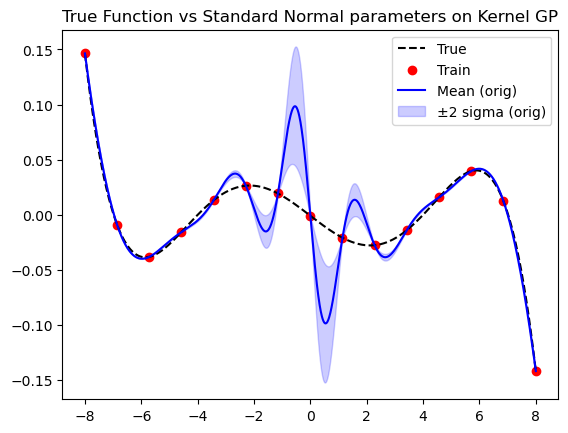

In [20]:
plt.plot(zgrid, fgrid, 'k--', label='True')
plt.scatter(z_train, y_train, c='r', label='Train')
plt.plot(zgrid, mu_0, 'b-', label='Mean (orig)')
plt.fill_between(zgrid.flatten(), mu_0-2*std_0,  mu_0+2*std_0, color='b', alpha=0.2, label='±2 sigma (orig)')
plt.legend()
plt.title("True Function vs Standard Normal parameters on Kernel GP")
plt.show()

## Plot the kernel

Original m,b,sigma_mb are:  1.0 1.0 0.0


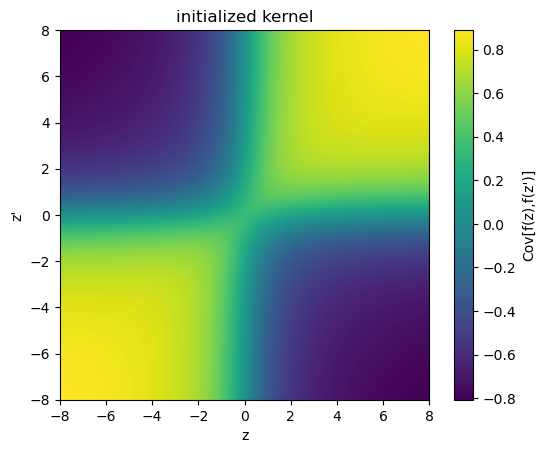

In [21]:
K = arcsin_kernel_joint_gaussian(zgrid, zgrid, s_m0, s_b0, s_mb0)
print("Original m,b,sigma_mb are: ",s_m0, s_b0, s_mb0)
plt.imshow(K, extent=[-8,8,-8,8], origin='lower')
plt.colorbar(label='Cov[f(z),f(z\')]')
plt.title("Prior Covariance")
# plt.savefig("initialized_Kernel_imshow.pdf", transparent=True)
plt.title("initialized kernel")
plt.xlabel("z")
plt.ylabel("z'")
plt.show()

## Optimize the Kernel Hyper-paramters

In [22]:
## Use scipy to optimize function
init = [np.log(s_m0), np.log(s_b0), s_mb0]
res = minimize(neg_log_marginal_likelihood, init, 
               args=(z_train,y_train), 
               bounds=[(-1.5,1.5),(-1.5,1.5),(None,None)])
log_sm, log_sb, phi = res.x
sigma_m_opt, sigma_b_opt = np.exp([log_sm,log_sb])
rho_opt = np.tanh(phi)
sigma_mb_opt = rho_opt*sigma_m_opt*sigma_b_opt

## GP predictions
mu_opt, cov_opt = gp_regression_eig_joint_gaussian(z_train,y_train,zgrid,sigma_m_opt,sigma_b_opt,sigma_mb_opt)
std_0 = np.sqrt(np.clip(np.diag(cov_0),0, np.inf))
std_opt = np.sqrt(np.clip(np.diag(cov_opt),0, np.inf))

## Plot resulting fit

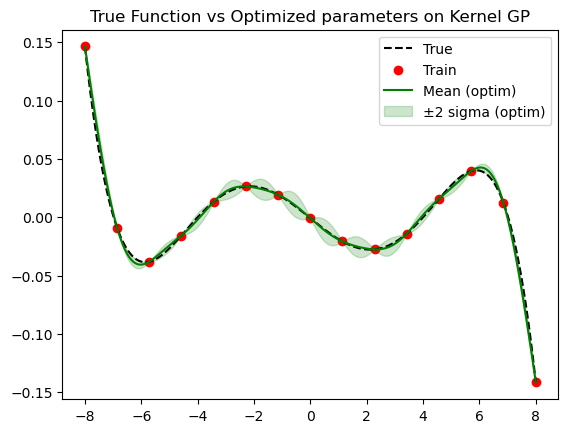

In [23]:
plt.plot(zgrid, fgrid, 'k--', label='True')
plt.scatter(z_train, y_train, c='r', label='Train')
plt.plot(zgrid, mu_opt, 'g-', label='Mean (optim)')
plt.fill_between(zgrid.flatten(), mu_opt-2*std_opt,  mu_opt+2*std_opt, color='g', alpha=0.2, label='±2 sigma (optim)')
plt.legend()
plt.title("True Function vs Optimized parameters on Kernel GP")
plt.show()

## Plot Resulting Optimized Kernel

Optimized m,b,sigma_mb are:  0.6416457319967743 4.4816890703380645 0.011473523516505213


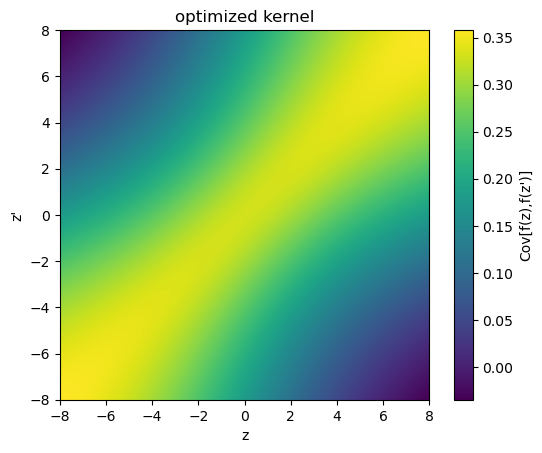

In [24]:
K = arcsin_kernel_joint_gaussian(zgrid, zgrid, sigma_m_opt, sigma_b_opt, sigma_mb_opt)
print("Optimized m,b,sigma_mb are: ",sigma_m_opt, sigma_b_opt, sigma_mb_opt)
plt.imshow(K, extent=[-8,8,-8,8], origin='lower')
plt.colorbar(label='Cov[f(z),f(z\')]')
plt.xlabel("z")
plt.ylabel("z'")
plt.title("optimized kernel")
plt.show()